In [43]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [44]:
# Path to the CSV file
file_path = '/content/Hurricane_irma.csv'

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
else:
    print(f"File found at: {file_path}")

File found at: /content/Hurricane_irma.csv


In [45]:
# Load and preprocess data
data = pd.read_csv(file_path)

# Check for required columns
if 'processed_data' not in data.columns or 'Humanitarian_Class' not in data.columns:
    raise KeyError("The dataset must contain 'processed_data' and 'Humanitarian_Class' columns.")

# Fill missing values in the 'processed_data' column and convert to string type
data['processed_data'] = data['processed_data'].fillna('').astype(str)

# Convert 'Humanitarian_Class' to string type
data['Humanitarian_Class'] = data['Humanitarian_Class'].astype(str)

# Display the first few rows of the dataset
print("Data preview:")
print(data.head())

Data preview:
                                          tweet_text  \
0  RT @MSN: Island of Barbuda 'literally under wa...   
1  RT @Reuters: Hurricane Irma threatens luxury T...   
2  RT @TheAnonJournal: BREAKING NEWS: Hurricane I...   
3  JUST IN: 11PM #Hurricane #Irma update. @ABC7Ne...   
4  RT @cnnbrk: Hurricane Irma destroys "upwards o...   

                                          Multiclass Binary_Class  \
0  infrastructure_and_utility_damage | Infrastruc...       Damage   
1            other_relevant_information | Non-Damage   Non-Damage   
2            other_relevant_information | Non-Damage   Non-Damage   
3            other_relevant_information | Non-Damage   Non-Damage   
4  infrastructure_and_utility_damage | Infrastruc...       Damage   

           Humanitarian_Class  \
0  other relevant information   
1  other relevant information   
2  other relevant information   
3  other relevant information   
4  other relevant information   

                                   

In [46]:
# Encode class labels
class_labels = sorted(data['Humanitarian_Class'].unique())
class_mapping = {label: idx for idx, label in enumerate(class_labels)}
data['Humanitarian_Class'] = data['Humanitarian_Class'].map(class_mapping)

# Print class distribution
print("Class distribution:")
print(data['Humanitarian_Class'].value_counts())

Class distribution:
Humanitarian_Class
2    3364
3     403
1     185
0      64
Name: count, dtype: int64


In [47]:
# Tokenize sentences into words
sentences = [sentence.split() for sentence in data['processed_data']]

# Prepare labels in categorical format
labels = tf.keras.utils.to_categorical(data['Humanitarian_Class'].values, num_classes=len(class_labels))

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

print("Data split into training and testing sets:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Data split into training and testing sets:
Training samples: 3212
Testing samples: 804


In [48]:
# Oversample minority classes using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_flat = [" ".join(sentence) for sentence in X_train]
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train_flat).reshape(-1, 1), y_train)

# Convert resampled data back to a list of words
X_train_resampled = [sentence.split() for sentence in X_train_resampled.flatten()]

print("Data after oversampling:")
print(f"Training samples after oversampling: {len(X_train_resampled)}")

Data after oversampling:
Training samples after oversampling: 10752


In [49]:
# Train Word2Vec model
word2vec_model = Word2Vec(X_train_resampled, vector_size=300, window=5, min_count=1, sg=0)

# Create embedding matrix
vocab_size = len(word2vec_model.wv.index_to_key)
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

print(f"Word2Vec model trained. Vocabulary size: {vocab_size}, Embedding dimension: {embedding_dim}")

Word2Vec model trained. Vocabulary size: 5866, Embedding dimension: 300


In [50]:
# Convert text to sequences
X_train_resampled = [[word_index.get(word, 0) for word in sentence] for sentence in X_train_resampled]
X_test = [[word_index.get(word, 0) for word in sentence] for sentence in X_test]

# Pad sequences to ensure uniform length
X_train_resampled = tf.keras.preprocessing.sequence.pad_sequences(X_train_resampled, maxlen=100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100)

print(f"Sequences padded. X_train_resampled shape: {X_train_resampled.shape}, X_test shape: {X_test.shape}")


Sequences padded. X_train_resampled shape: (10752, 100), X_test shape: (804, 100)


In [51]:
# Calculate class weights to handle class imbalance
class_weights = {i: len(y_train_resampled) / (len(class_labels) * np.bincount(np.argmax(y_train_resampled, axis=1))[i]) for i in range(len(class_labels))}

print("Class weights calculated.")


Class weights calculated.


In [52]:

# Define and compile the CNN model
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False),
    Conv1D(100, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.02),
    Conv1D(150, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    BatchNormalization(),
    Dropout(0.02),
    Conv1D(200, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

print("Model training completed.")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


269/269 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4792 - loss: 1.4073 - val_accuracy: 0.0000e+00 - val_loss: 11.0524
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5977 - loss: 0.9767 - val_accuracy: 0.0000e+00 - val_loss: 10.3521
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6726 - loss: 0.8260 - val_accuracy: 0.0000e+00 - val_loss: 1.3854
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7090 - loss: 0.7579 - val_accuracy: 0.0000e+00 - val_loss: 10.4942
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7375 - loss: 0.6602 - val_accuracy: 0.0000e+00 - val_loss: 2.6378
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7464 - loss: 0.6351 - val_accuracy: 0.0000e+00 - val_loss: 3.1349
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7525 - loss: 0.6135 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7546 - loss: 0.

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Classification Report:
                                         precision    recall  f1-score   support

                   affected individuals       0.00      0.00      0.00        15
      infrastructure and utility damage       0.00      0.00      0.00        36
             other relevant information       0.00      0.00      0.00       676
rescue, volunteering or donation effort       0.10      1.00      0.17        77

                               accuracy                           0.10       804
                              macro avg       0.02      0.25      0.04       804
                           weighted avg       0.01      0.10      0.02       804



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


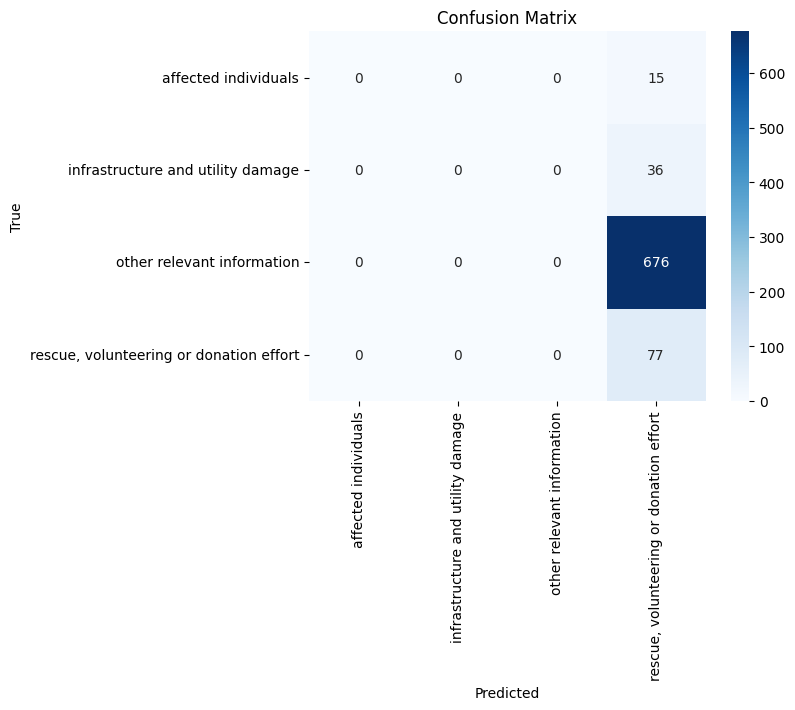

Model evaluation completed.


In [53]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, labels=range(len(class_labels)), target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=range(len(class_labels)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation completed.")
